In [1]:
""" First close look at eye tracking, statistics, heatmaps ,etc.

Is looking predictive of where draw?

"""

' First close look at eye tracking, statistics, heatmaps ,etc.\n\nIs looking predictive of where draw?\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from neuralmonkey.classes.session import Session
import matplotlib.pyplot as plt
from neuralmonkey.scripts.load_and_save_locally import load_and_preprocess_single_session
import neuralmonkey.utils.monkeylogic as mkl
from neuralmonkey.classes.session import load_session_helper, load_mult_session_helper
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATE = 220606
DATE = 231103
# DATE = 220901
animal = "Pancho"

In [4]:
DATE = 230630
animal = "Diego"

Searching using this string:
/home/lucas/mnt/Freiwald/ltian/recordings/*Diego*/*230630*/**
Found this many paths:
1
---
/home/lucas/mnt/Freiwald/ltian/recordings/Diego/230630/Diego-230630-124955
session:  0
Beh Sessions that exist on this date:  {230630: [(1, 'primsingridfixed6fDiego')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['primsingridfixed6fDiego']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/lucas/mnt/Freiwald/ltian/recordings/*Diego*/*230630*/**
Found this many paths:
1
---
/home/lucas/mnt/Freiwald/ltian/recordings/Diego/230630/Diego-230630-124955
Searching using this string:
/home/lucas/mnt/Freiwald_kgupta/kgupta/neural_data/*Diego*/*230630*/*Diego*230630**
Found this many paths:
1
---
/home/lucas/mnt/Freiwald_kgupta/kgupta/neural_data/Diego/230630/Diego-230630-124955
These durations gotten for sessions...
...  _durations_each_sess_using_tank : [14115.359024]
...  onset

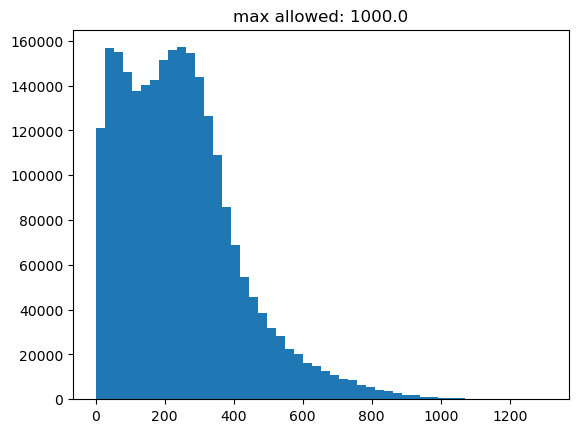

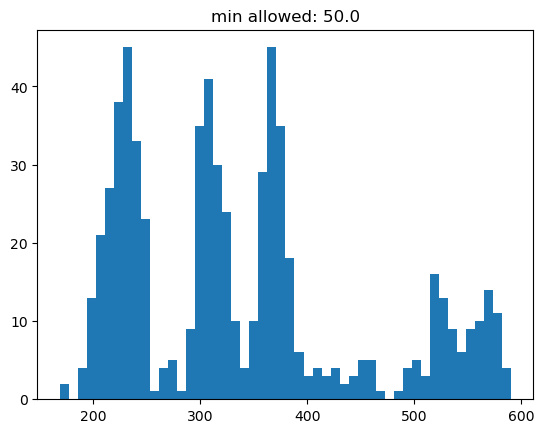

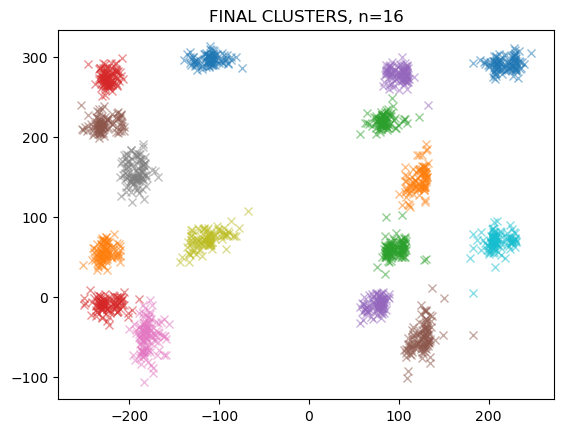

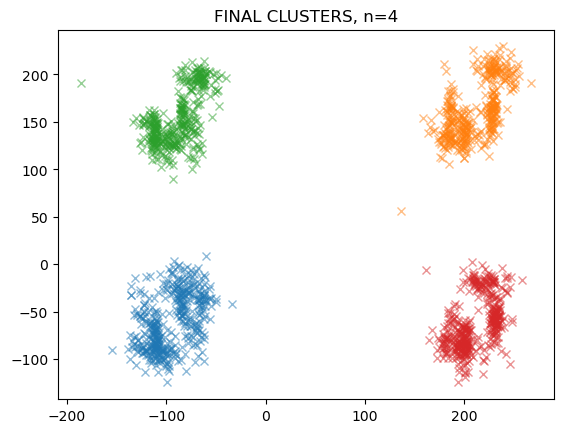

In [5]:
# %matplotlib inline
# to help debug if times are misaligned.
MS = load_mult_session_helper(DATE, animal)
    


### Load and quick plots of eye

In [ ]:
SN = MS.SessionsList[0]

In [ ]:
SN._CachedTrialOnset

In [ ]:
trials = SN.get_trials_list(True)
trials

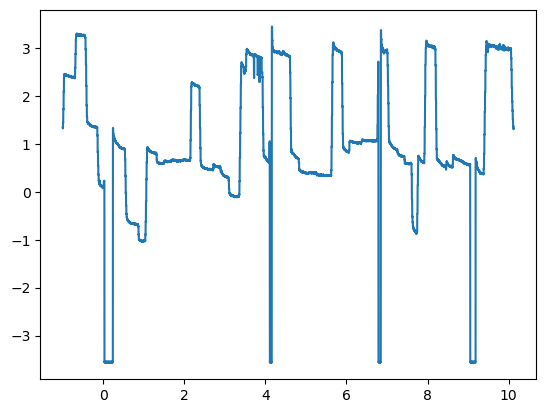

In [16]:
# SN.plot_stream(trial=trials[0], which="eyex")
sn.plot_stream(trial=trials[0], which="eyex")

In [ ]:
%matplotlib inline

In [ ]:
# Convert eye tracking to location


##### Load calibrate eye data

In [ ]:
SN.load_behavior()

In [ ]:
# Developiung code to optimize alignment beween tdt and ml2.
times_tdt, vals_tdt, fs_tdt, times_ml2, vals_ml2, fs_ml2, fd = SN._beh_extract_eye_raw(100)
vals_tdt_calibrated = SN._beh_extract_eye_calibrate_raw(vals_tdt, fd)

SN._BehEyeAlignOffset = None

SN._beh_extract_eye_return_alignment_offset()

In [17]:
%matplotlib inline
CHECK_TDT_ML2_MATCH = True
apply_empirical_offset = True
return_all = False
times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trials[100], CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=True, 
                                                         apply_empirical_offset=apply_empirical_offset, return_all=return_all)

NameError: name 'SN' is not defined

In [ ]:
apply_empirical_offset = True
PLOT = False
CHECK_TDT_ML2_MATCH = True
for trial in SN.get_trials_list(True)[::10]:
    print(trial)
    times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trial, CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=PLOT, apply_empirical_offset=apply_empirical_offset)

### [FOR KEDAR] load eye tracking and plot over behavior

In [131]:
def _plot_eye_trace(times, vals, ax, color="b"):
    ax.plot(vals[:,0], vals[:,1], "-k", alpha=0.3)
    ax.scatter(vals[:,0], vals[:,1], c=times, alpha=0.5, marker="o")    


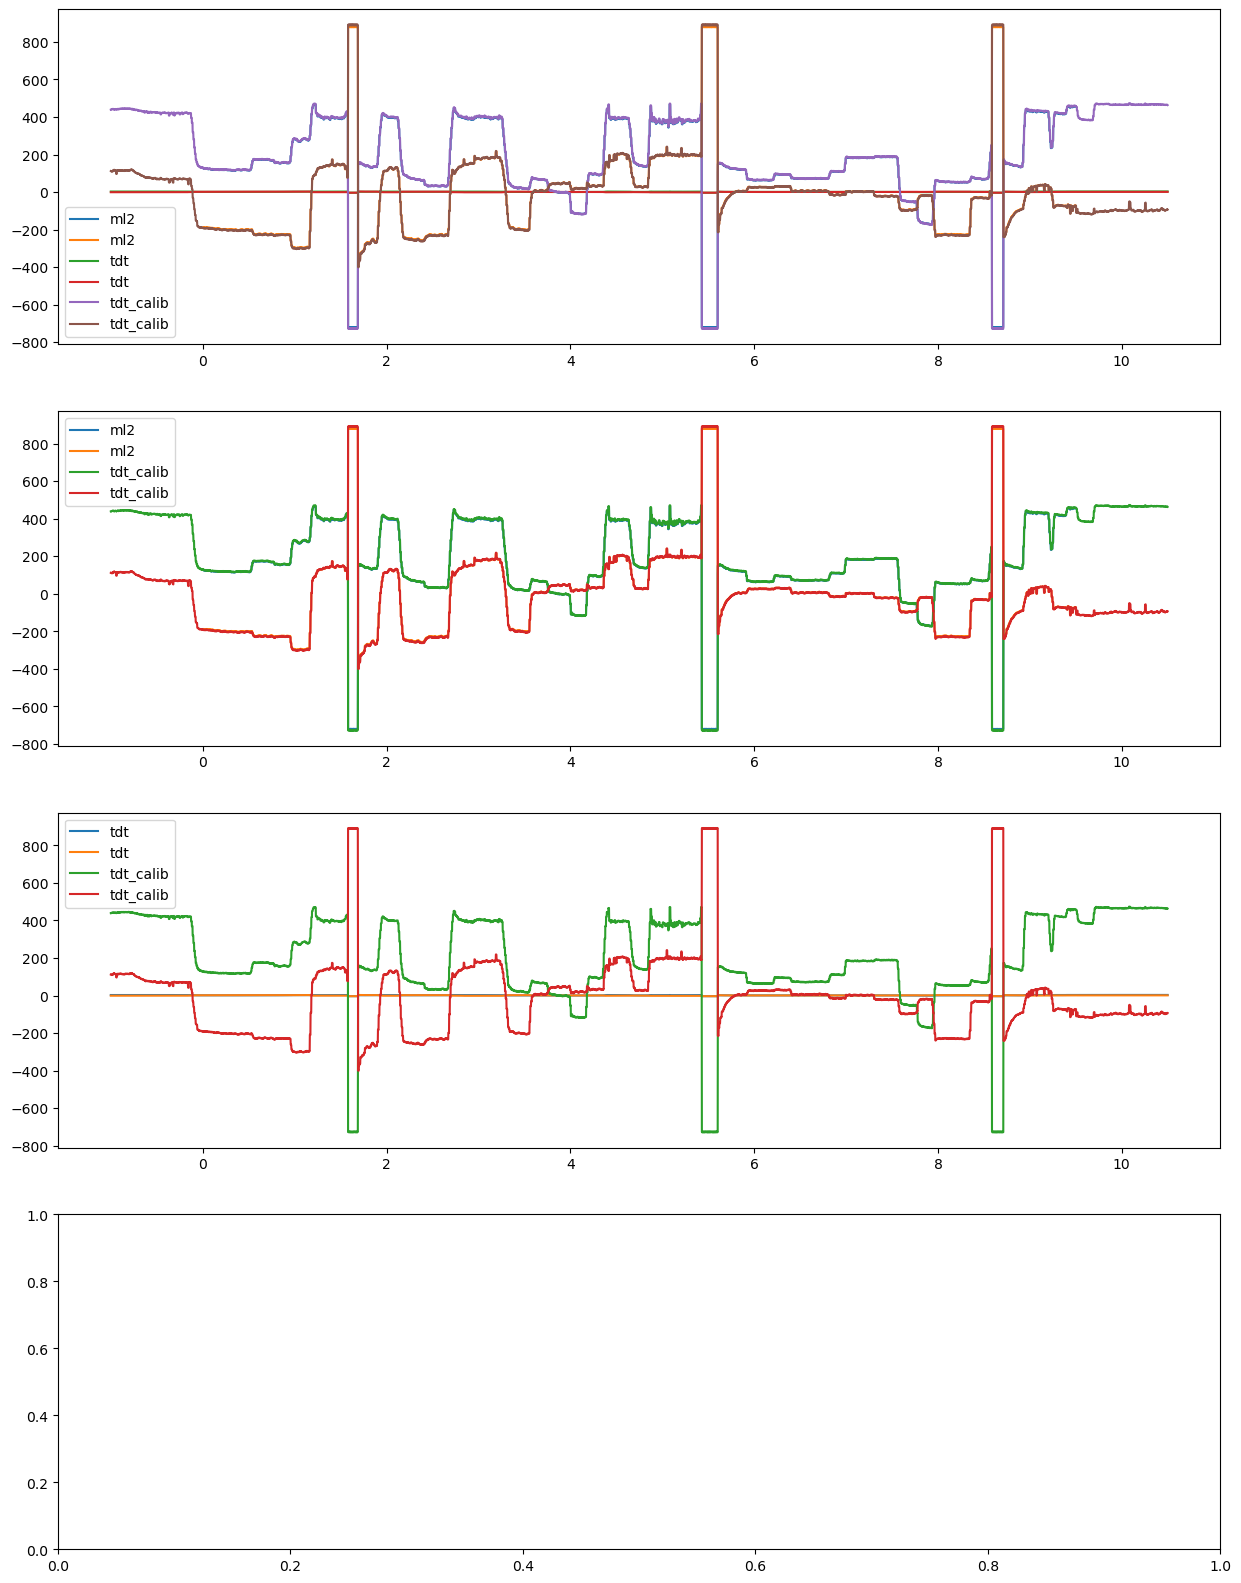

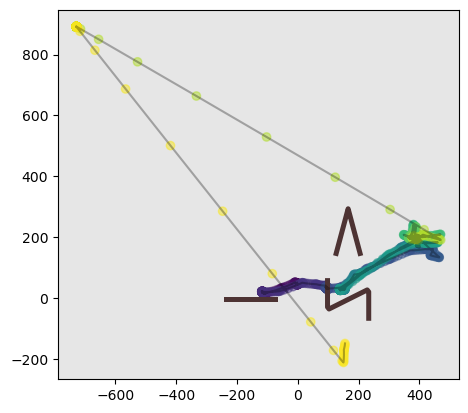

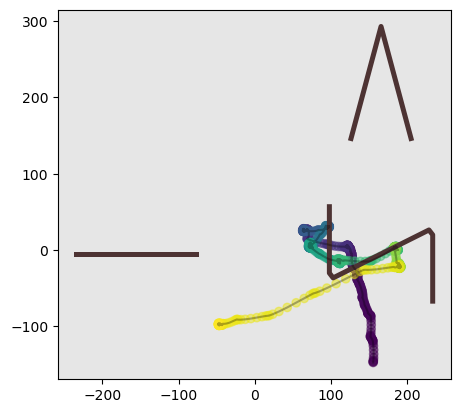

In [132]:
################ PARAMS
sn = MS.SessionsList[0]
PLOT_SM = True # smoothed?
trial = sn.get_trials_list(True)[-1]


In [135]:
trial 

113

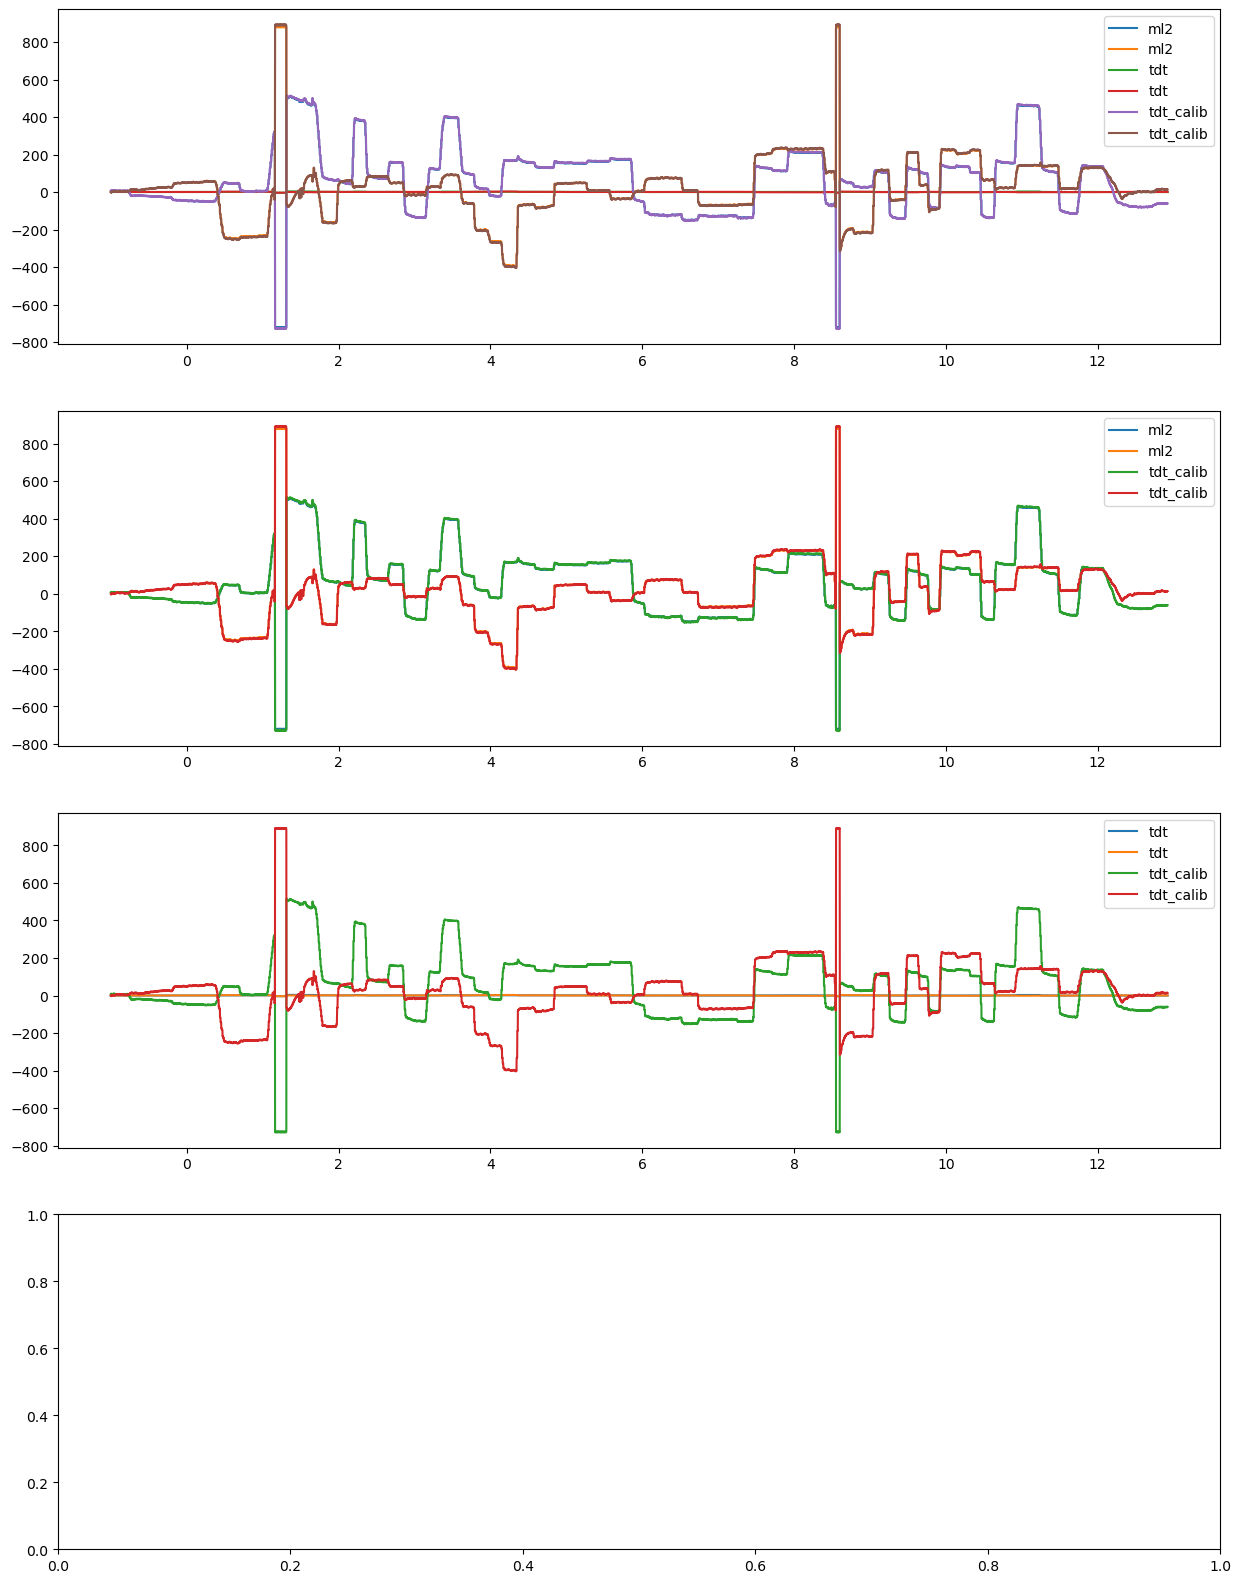

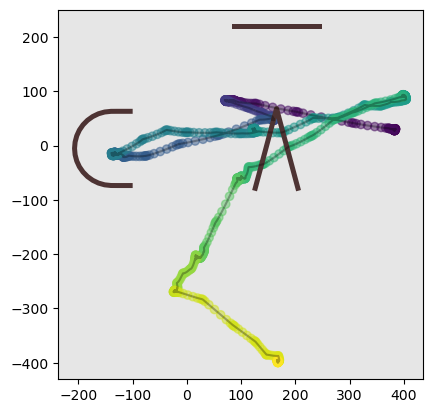

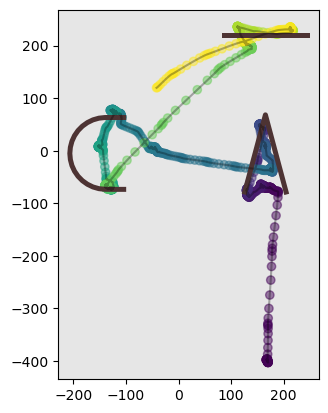

In [136]:

############### RUN
times_tdt, vals_tdt_calibrated, fs_tdt, vals_tdt_calibrated_sm = sn.beh_extract_eye_good(trial, PLOT=True, return_all=True);

if PLOT_SM:
    VALS = vals_tdt_calibrated_sm
else:
    VALS = vals_tdt_calibrated
    
############### 1) Plot during planning
# Overlay on task and beh
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)

# sn.Datasetbeh.plot_strokes([VALS], ax)
# _plot_eye_trace(VALS, ax, "r")

# keep just times during "planning"
dict_event_times = sn.events_get_time_sorted(trial)[0]
t1 = dict_event_times["stim_onset"]
t2 = dict_event_times["go"]

inds = (times_tdt>=t1) & (times_tdt<=t2)
times_this = times_tdt[inds]
vals_this = VALS[inds]

# sn.Datasetbeh.plot_strokes([vals_this], ax, single_color="r", alpha=0.5)
_plot_eye_trace(times_this, vals_this, ax)

############### 2) Plot during strokes
# Overlay on task and beh
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)


dict_event_times = sn.events_get_time_sorted(trial)[0]
ons, offs = sn.strokes_extract_ons_offs(trial)
t1 = dict_event_times["go"]
t2 = offs[-1]

inds = (times_tdt>=t1) & (times_tdt<=t2)
times_this = times_tdt[inds]
vals_this = VALS[inds]

# sn.Datasetbeh.plot_strokes([vals_this], ax, single_color="r", alpha=0.5)
_plot_eye_trace(times_this, vals_this, ax)


In [ ]:
# Extract task stroke shapes, including their locations, etc.
ind = sn.datasetbeh_trial_to_datidx(trial)
tokens_task = sn.Datasetbeh.taskclass_tokens_extract_wrapper(ind, "task", plot=True)
tokens_beh = sn.Datasetbeh.taskclass_tokens_extract_wrapper(ind, "beh", plot=False)

# 

In [ ]:
# Tokens holds each prim (either beh or task) as a discrete object

# This gives useful features for the first prim in the task
tokens_task[0]

In [ ]:
### to get times of events in the trial:
dict_event_times = sn.events_get_time_sorted(trial)

# - you can pick events form tjhis list:
print(sn.events_default_list_events())

# -- such as this:
dict_event_times = sn.events_get_time_sorted(trial, list_events=['samp', 'go', 'first_raise'])
print(dict_event_times)

### to get times of strokes
ons, offs = sn.strokes_extract_ons_offs(trial)
print(ons, offs)

In [ ]:
# To get spatial coordinates of task strokes
sn.strokes_task_extract(trial)

# [GOOD] Clusterfix wrapper for extraction (written by Kedar)

### Extract from raw

In [ ]:
# Notes, sanity checks of this code by me. Looking closely through:
# 1. extract_and_save_clusterfix_trial_xy_mats - DONE
# 2. self.extract_and_save_clusterfix_results_mat() - NOT DONE
# 3. self.extract_and_save_clusterfix_trial_fixsacc_csvs() - NOT DONE

# NOTE: sanity checka fter, pllotting results over raw , looks good.

In [33]:
for sn in MS.SessionsList:
    sn.extract_and_save_clusterfix_results()

exporting xy mats...
trials: [21, 44, 65, 87, 109, 134, 187, 209, 294, 316, 338, 362, 384, 428, 453, 486, 554, 650, 674, 708, 734, 759, 806, 828, 858, 984, 1011, 1036, 1062, 1153]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.14059148]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.86898318]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.07545016]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.11903264]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.04392691]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.40190727]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.96722212]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.63712981]
This is 10th percentile of r

# Assign each fixation to a shape x loc


### First, sanity chekc that fixations from this dataset are closely preceded by saccades (~0.1 ms sacc durations). This is just for you, to be confident in extracted data.

This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.03128321]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.03128321]


[0.5154448325855712,
 0.9355770494634387,
 1.1456431579023727,
 1.5407675047279863,
 1.6608052809788054,
 1.885876111449092,
 2.110946941919378,
 2.6561185090585155,
 3.2463042422917106,
 3.541397108908308,
 3.9815356218279794,
 4.156590712193757,
 4.341648950580437,
 4.631740243186584,
 4.831803203604616,
 5.066877182095804,
 5.401982640796008,
 5.577037731161786,
 6.9724768800775605,
 7.547657891279403,
 7.757723999718338,
 7.927777516073664,
 8.332905010920177,
 8.542971119359112,
 8.688016765662187,
 8.908086022122022,
 9.193175740717718,
 9.678328419731447]

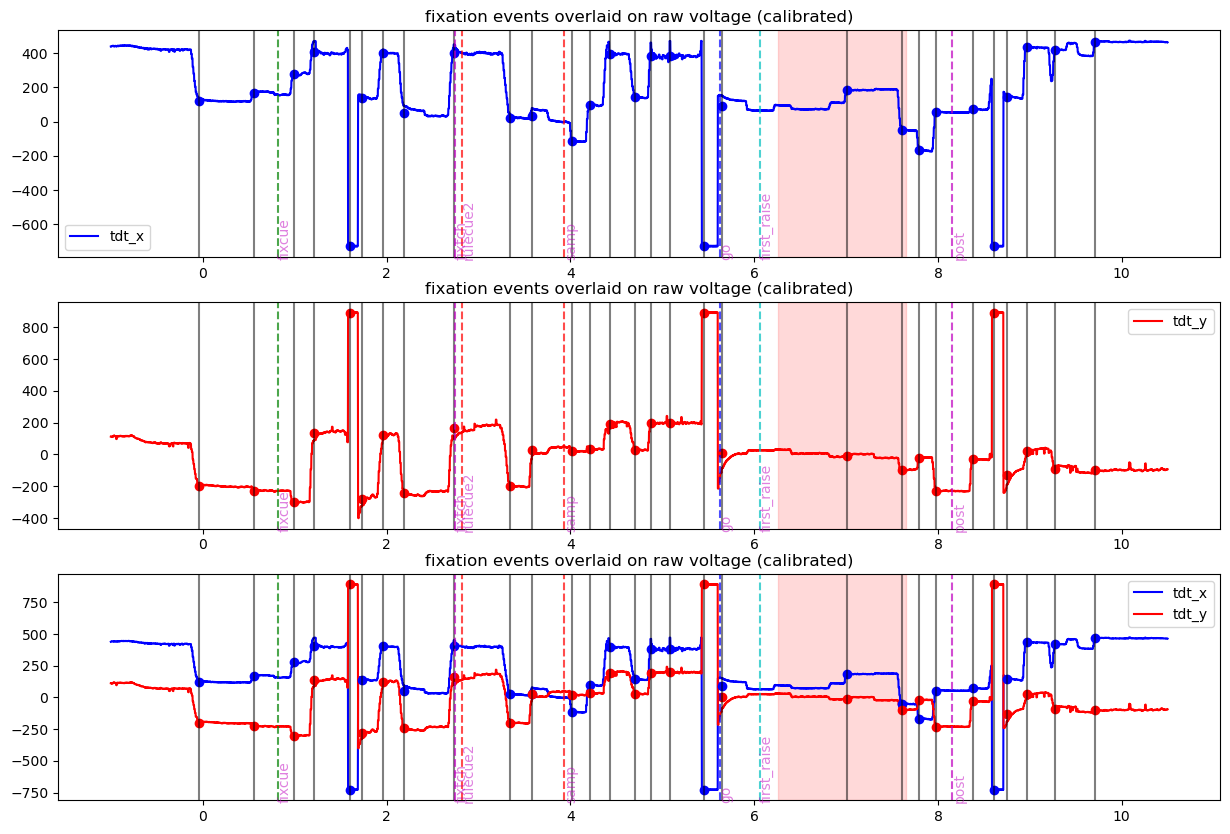

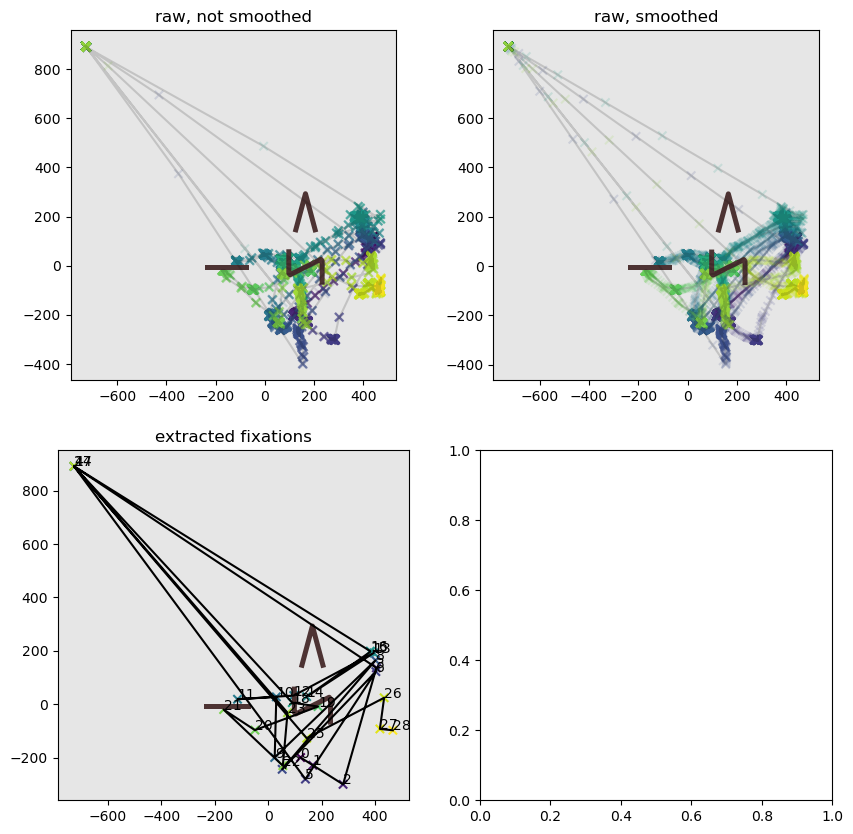

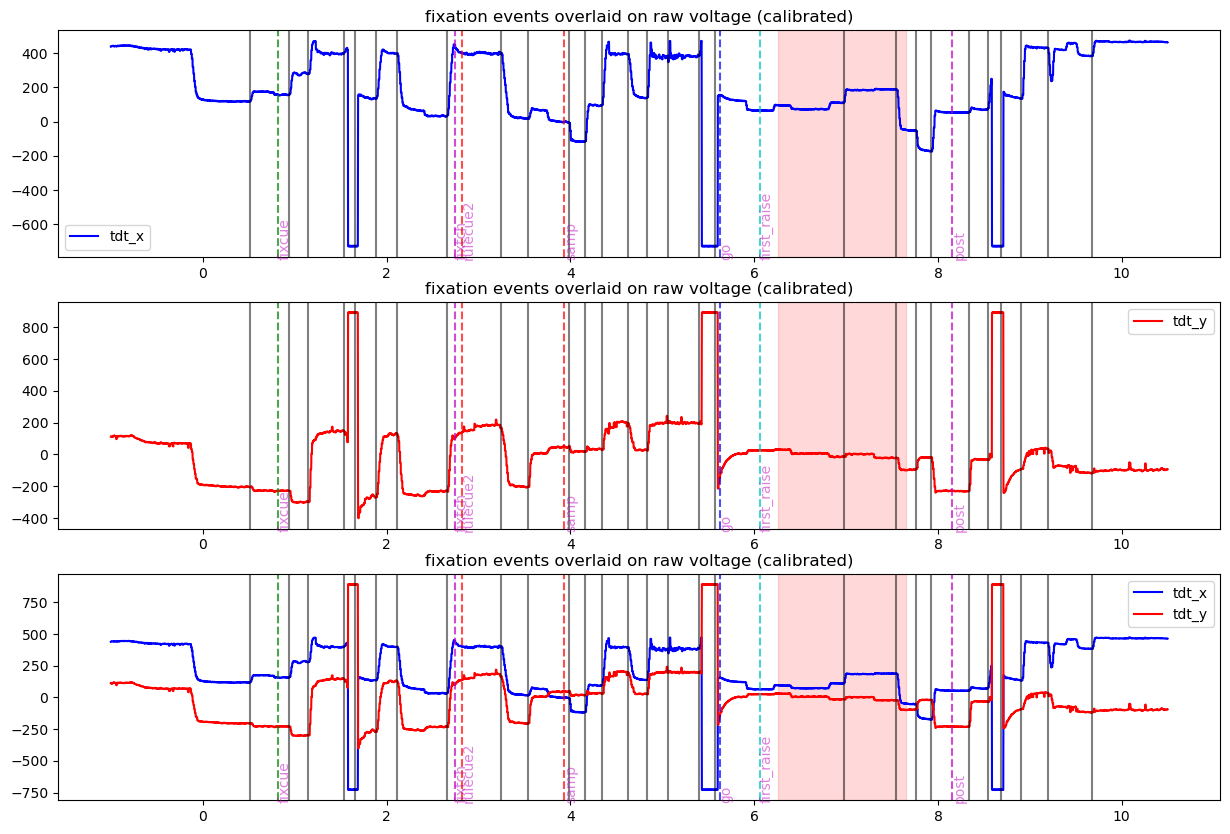

In [454]:
# Plot, for a single trial, the fixations and saccades
sn.events_get_clusterfix_fixation_times_and_centroids(trial, plot_overlay_on_raw=True)
sn.events_get_clusterfix_saccade_times(trial, on_or_off=True, plot_overlay_on_raw=True)


##### Go thru all trials, and get global distribution over saccade durations

This fraction of saccades had duration longer than 0.2: 0.00223412041138631


0.09502990619856533

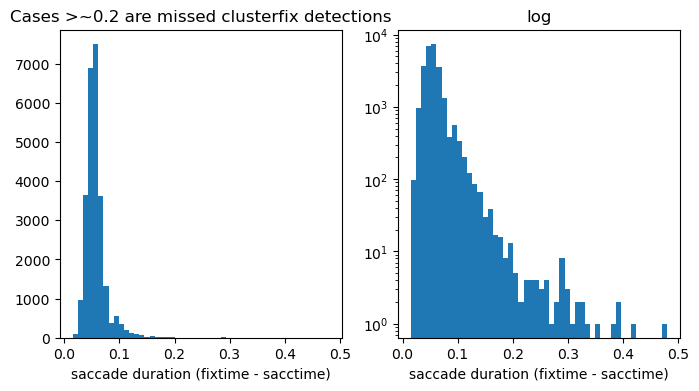

In [453]:
# Get fixation and saccade pairs
saccade_durations = []

for trial in sn.get_trials_list():
    times_fix, data_centroids = sn.events_get_clusterfix_fixation_times_and_centroids(trial)
    times_saccon =sn.events_get_clusterfix_saccade_times(trial, on_or_off=True)

    times_fix = np.array(times_fix)
    times_saccon = np.array(times_saccon)

    # inds_keep_fix = None
    # inds_keep_sacc = None
    inds_keep_fix = list(range(len(times_fix)))
    inds_keep_sacc = list(range(len(times_saccon)))
    if len(times_fix)==len(times_saccon):
        if times_fix[0] - times_saccon[0]>0:
            # good
            pass
        else:
            # shifted
            inds_keep_fix = inds_keep_fix[1:]
            inds_keep_sacc = inds_keep_sacc[:-1]
    elif len(times_fix)==len(times_saccon)+1:
        inds_keep_fix = inds_keep_fix[1:]
    elif len(times_fix)==len(times_saccon)-1:
        inds_keep_sacc = inds_keep_sacc[:-1]
    else:
        print(len(times_fix))
        print(len(times_saccon))
        print(times_fix)
        print(times_saccon)
        
        fig, ax = plt.subplots()
        ax.plot(times_saccon, times_fix, "ok")
        ax.plot([0, 10], [0, 10])

        assert False

    # take final 
    times_fix = times_fix[inds_keep_fix]
    times_saccon = times_saccon[inds_keep_sacc]
    
    # sanity check that fixations occur consistenyl and shortly after saccs
    assert len(times_saccon) == len(times_fix)
    assert np.all((times_fix - times_saccon)>0)
    assert np.all(np.max(times_fix - times_saccon)<0.5) # this would be really bad. 
    saccade_durations.extend(times_fix - times_saccon)
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax=axes.flatten()[0]
ax.hist(saccade_durations, bins=50, log=False)
ax.set_xlabel("saccade duration (fixtime - sacctime)")
ax.set_title("Cases >~0.2 are missed clusterfix detections")

ax=axes.flatten()[1]
ax.hist(saccade_durations, bins=50, log=True)
ax.set_xlabel("saccade duration (fixtime - sacctime)")
ax.set_title("log")
MAX_SACC_DUR = 0.2
frac_toolong_saccades = sum(np.array(saccade_durations)>MAX_SACC_DUR)/len(saccade_durations)
print(f"This fraction of saccades had duration longer than {MAX_SACC_DUR}: {frac_toolong_saccades}")
np.max(times_fix - times_saccon)

print("Confirm by eye that most fixations are preceded by saccade less than ~150ms before it.")

### Second, extract fixations for each trial

This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.04113428]


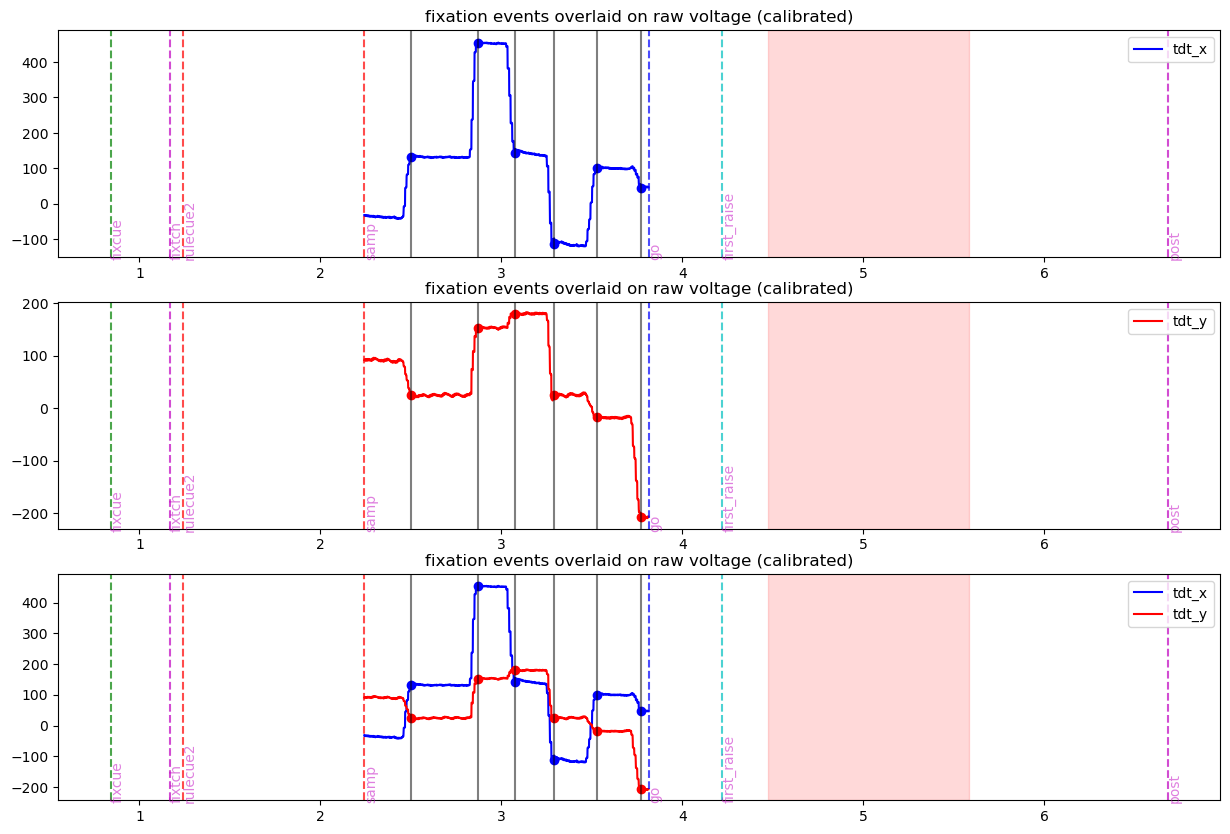

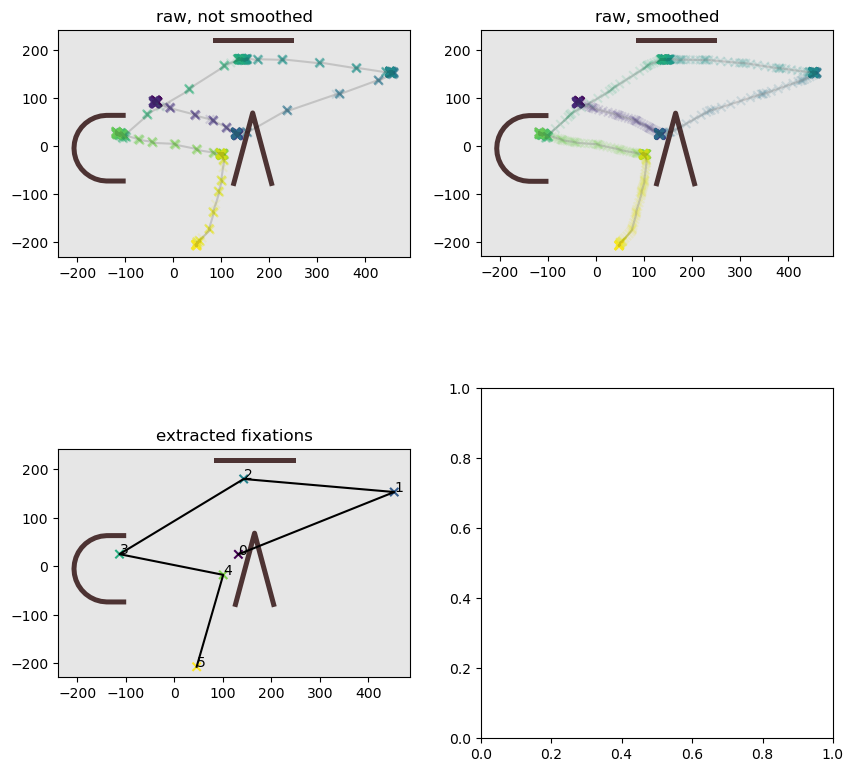

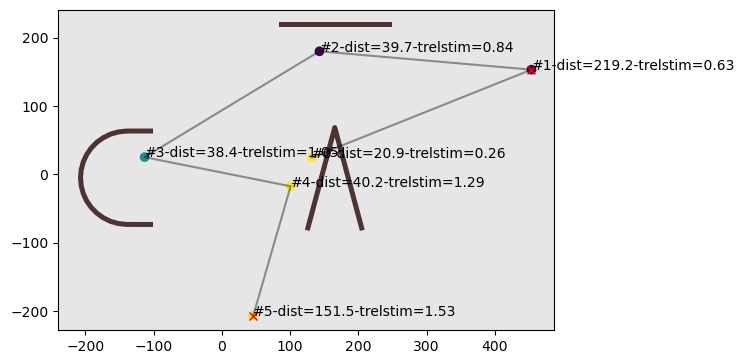

In [480]:
# Run for a single trial, making example plots
trials = sn.get_trials_list()
trial = trials[222]
dffix = sn.beh_eye_fixation_extract_and_assign_task_shape(trial, event_endpoints=["stim_onset", "go"], PLOT=True)


In [464]:
# Collect across all data
trials = sn.get_trials_list()

list_df = []
for t in trials:
    print(t)
    dffix = sn.beh_eye_fixation_extract_and_assign_task_shape(t, event_endpoints=["stim_onset", "go"], PLOT=False)
    
    dffix["trialcode"] = sn.datasetbeh_trial_to_trialcode(t)
    
    list_df.append(dffix)

DFfix = pd.concat(list_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
345
346
348
349
350
351
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
3

##### To save, for Dolnik, removing custom classes

In [470]:
DFfix = DFfix.drop(["assigned_task_token"], axis=1)
dd

In [471]:
path = f"/home/lucas/Dropbox/SCIENCE/FREIWALD_LAB/DATA/Dolnik/{animal}-{DATE}-fixations.pkl"
DFfix.to_pickle(path)

In [481]:
DFfix

,idx_fixation,time_global,fix_cen,time_rel_stim_onset,closest_task_token_dist,closest_task_token_idx,assigned_task_shape,assigned_task_gridloc,assigned_task_idx_task_orig,trialcode
0,0,3.411092,"[465.3719938048766, 186.44580206886937]",0.280614,232.283157,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,230630-1-1
1,1,3.966189,"[162.18216686600786, 202.16162724582293]",0.835711,14.585344,0,zigzagSq-1-1-1,"(1, 1)",0,230630-1-1
2,2,4.191228,"[480.87315540128975, 186.90787276227704]",1.060750,247.784269,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,230630-1-1
0,0,2.417192,"[101.55874170954712, 2.727408041941346]",0.104788,44.833743,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,230630-1-2
1,1,2.592302,"[211.4610124108076, 81.45383904971334]",0.279898,47.922614,0,V-2-2-0,"(1, 0)",0,230630-1-2
...,...,...,...,...,...,...,...,...,...,...
2,2,4.436679,"[395.191679038676, 192.33827966383788]",0.502342,195.980444,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,230630-1-1154
3,3,4.701762,"[143.6973371220526, 28.474982018432648]",0.767425,39.960747,2,zigzagSq-1-1-1,"(1, 0)",2,230630-1-1154
4,4,4.881819,"[381.4729971429457, 196.17580229014163]",0.947482,183.682185,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,230630-1-1154
5,5,5.086883,"[382.0594853858116, 198.92142265374545]",1.152546,185.010049,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,230630-1-1154
